In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv("da_internship_task_dataset.csv")

#### Quick overview

In [32]:
df.head(n=10)

,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88
5,user_97,2025-05-14,Basic,Model_A,Feature_1,10.0,3.01
6,user_338,2025-04-19,Basic,Model_A,Feature_3,13.0,5.29
7,user_433,2025-05-28,Enterprise,Model_E,Feature_1,81.0,14.19
8,user_81,2025-03-19,Standard,Model_E,Feature_3,59.0,12.92
9,user_311,2025-03-07,Standard,Model_D,Feature_1,56.0,12.12


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   uuid          122746 non-null  object        
 1   day_id        122746 non-null  datetime64[ns]
 2   license       122746 non-null  object        
 3   model         122746 non-null  object        
 4   feature       122746 non-null  object        
 5   requests_cnt  122746 non-null  float64       
 6   spent_amount  122746 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 6.6+ MB


In [30]:
df["day_id"] = pd.to_datetime(df["day_id"], format="%Y-%m-%d")

In [6]:
df.describe()

,requests_cnt,spent_amount
count,122746.000000,122746.000000
mean,51.260742,12.227798
std,167.977380,37.588494
min,1.000000,0.270000
25%,18.000000,5.140000
50%,32.000000,8.020000
75%,54.000000,13.060000
max,12900.000000,2599.000000


In [26]:
df.duplicated().sum()

np.int64(0)

General observations:
- there are no missing values
- 

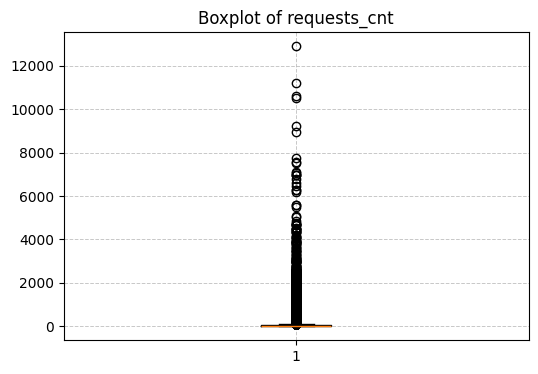

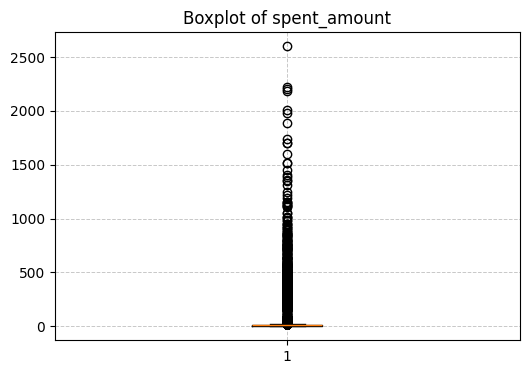

In [14]:
cols = ['requests_cnt', 'spent_amount']

for col in cols:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col], label=col)
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    plt.title(f'Boxplot of {col}')
plt.show()

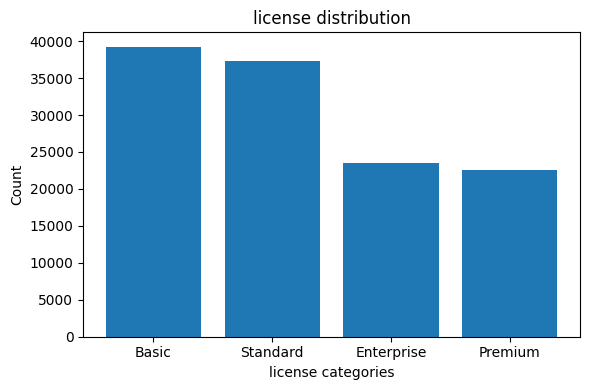

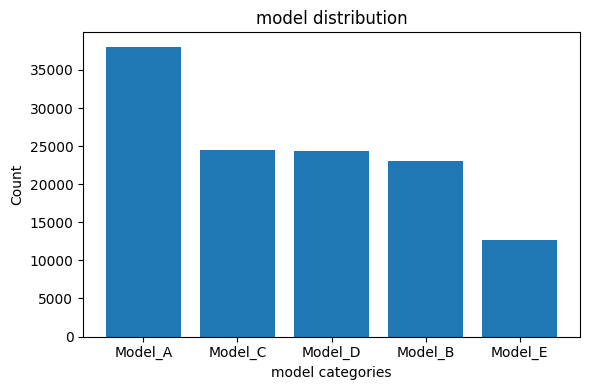

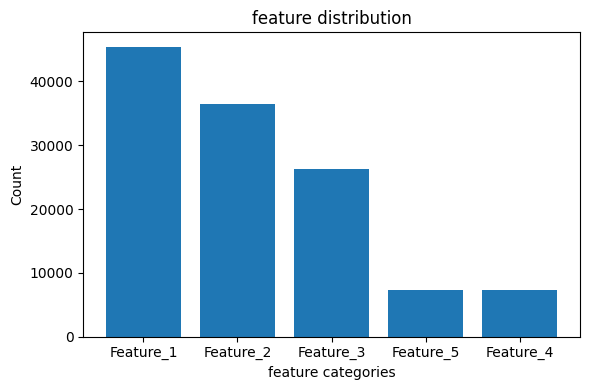

In [27]:
cat_cols = ["license", "model", "feature"]

for col in cat_cols:
    counts = df[col].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f'{col} distribution')
    plt.xlabel(f'{col} categories')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

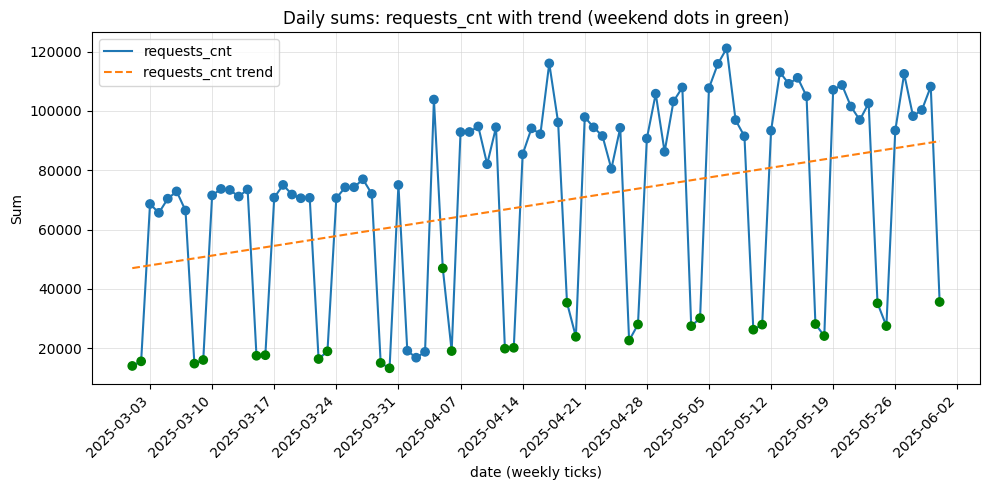

In [54]:
import matplotlib.dates as mdates

df_day = df.groupby('day_id')[['spent_amount', 'requests_cnt']].sum().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(df_day.index, df_day['requests_cnt'], label='requests_cnt')

x = np.arange(len(df_day))
coeffs = np.polyfit(x, df_day['requests_cnt'].values, 1)
trend = np.poly1d(coeffs)(x)
plt.plot(df_day.index, trend, linestyle='--', color='C1', label='requests_cnt trend')

marker_colors = ['green' if d.weekday() >= 5 else 'C0' for d in df_day.index]
plt.scatter(df_day.index, df_day['requests_cnt'], color=marker_colors, zorder=3)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True, which='major', color='lightgrey', linestyle='-', linewidth=0.7, alpha=0.6)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('date (weekly ticks)')
plt.ylabel('Sum')
plt.title('Daily sums: requests_cnt with trend (weekend dots in green)')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

['green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green', 'green', 'C0', 'C0', 'C0', 'C0', 'C0', 'green']
